<a href="https://colab.research.google.com/github/zhuyuan7/lstm_stock/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import files
uploaded = files.upload()

Saving FileName2.csv to FileName2.csv


In [2]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['FileName2.csv']))
df.head()

,Unnamed: 0,Headline,Timestamp,result,ms_today,ms_tomorrow,normalized_headline
0,24,Sensex falls ahead of GST; set for first month...,2017-06-30,True,1,0,sensex falls ahead of gst; set for first month...
1,46,"Sensex trades flat, Nifty below 9,500; broader...",2017-06-30,True,1,0,"sensex trades flat, nifty below 9,500; broader..."
2,89,"Sensex trades lower, Nifty below 9,500; BSE Mi...",2017-06-30,True,1,0,"sensex trades lower, nifty below 9,500; bse mi..."
3,90,"Market in wait and watch, Sensex slips over 15...",2017-06-30,True,1,0,"market in wait and watch, sensex slips over 15..."
4,112,"Markets Live: Sensex, Nifty fall steeply ahead...",2017-06-30,True,1,0,"markets live: sensex, nifty fall steeply ahead..."


In [3]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(df["Headline"].values, df['ms_today'].values, random_state=42)

In [4]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 80  # Max number of words kept at the end of each text

In [7]:
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

In [8]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline
import numpy as np


batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
    """ Model creation function: returns a compiled Bidirectional LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=10, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(texts_train, y_train);

<ipython-input-9-ecc6852cbddc>:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=10, batch_size=batch_size,
<ipython-input-7-b625c09b60cb>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


Epoch 1/10
232/232 [==============================] - 181s 741ms/step - loss: 0.6263 - accuracy: 0.6517
Epoch 2/10
232/232 [==============================] - 180s 776ms/step - loss: 0.5587 - accuracy: 0.7163
Epoch 3/10
232/232 [==============================] - 175s 753ms/step - loss: 0.5186 - accuracy: 0.7396
Epoch 4/10
232/232 [==============================] - 176s 758ms/step - loss: 0.4867 - accuracy: 0.7554
Epoch 5/10
232/232 [==============================] - 174s 750ms/step - loss: 0.4576 - accuracy: 0.7708
Epoch 6/10
232/232 [==============================] - 172s 743ms/step - loss: 0.4357 - accuracy: 0.7819
Epoch 7/10
232/232 [==============================] - 173s 747ms/step - loss: 0.4154 - accuracy: 0.7911
Epoch 8/10
232/232 [==============================] - 175s 756ms/step - loss: 0.4029 - accuracy: 0.7958
Epoch 9/10
232/232 [==============================] - 172s 743ms/step - loss: 0.3877 - accuracy: 0.8045
Epoch 10/10
232/232 [==============================] - 174s 751m

In [10]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(texts_test)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))

Computing predictions on test set...


<ipython-input-7-b625c09b60cb>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


155/155 [==============================] - 16s 95ms/step
Test accuracy: 71.12 %


In [11]:
# We choose a sample from test set
idx = 1000
text_sample = texts_test[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 10000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Sample 1000: last 10000 words (only part used by the model)
--------------------------------------------------
Live: Sensex Edges Higher; Bank of Baroda, SBI Surge
--------------------------------------------------
1/1 [==============================] - 0s 56ms/step
Probability(positive) = 0.5602911
True class: negative


In [12]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=4aafd6804cf6135c1ba6eb2e21910663e654ccc58a18e85f9ff310a99b9f20f8
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


  1/157 [..............................] - ETA: 13s

<ipython-input-7-b625c09b60cb>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


157/157 [==============================] - 21s 131ms/step


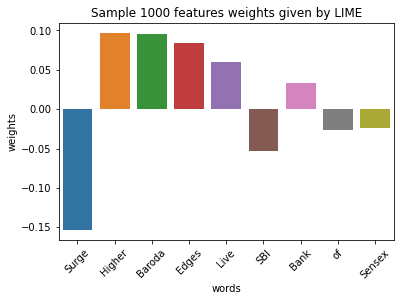

In [13]:
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt


explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=100)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));